# Обучение эмбеддингов (Metric Learning)
Данные, необходимые для этого модуля:
* symbol_a1.png
* symbol_a2.png
* symbol_b1.png

## Переключение версии TensorFlow

In [12]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [13]:
# %matplotlib inline  # Команда для Jupyter Notebook, чтобы графики из matplotlib отображались прямо в ноутбуке

import matplotlib.pyplot as plt  # Импорт библиотеки matplotlib для построения графиков. plt — сокращение для удобства
import numpy as np  # Импорт библиотеки numpy, которая нужна для работы с массивами и числовыми операциями
from sklearn.manifold import TSNE  # Импорт алгоритма t-SNE из библиотеки sklearn для визуализации высокоразмерных данных в 2D или 3D

import tensorflow as tf  # Импорт библиотеки TensorFlow — фреймворка для создания и обучения нейронных сетей


## Загрузка и подготовка датасета MNIST

In [14]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
# Загружаем набор данных MNIST через встроенный модуль TensorFlow Keras.
# MNIST — это база из 70,000 изображений рукописных цифр (0-9).
# train_x, train_y — обучающие изображения и их метки (цифры),
# test_x, test_y — тестовые изображения и их метки.

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
# reshape(-1, 28, 28, 1):
# Изменяем форму массива train_x.
# -1 значит «подставить автоматически размер по количеству образцов».
# 28x28 — размер каждого изображения в пикселях.
# 1 — количество цветовых каналов (1 — значит изображение черно-белое).
#astype(np.float32):
# Преобразуем данные в тип с плавающей точкой 32-бит для совместимости с TensorFlow.
#/ 255.:
# Нормализуем значения пикселей от 0–255 в диапазон 0–1, чтобы улучшить обучение нейросети.

test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
# Аналогично для тестового набора данных.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Визуализация датасета MNIST

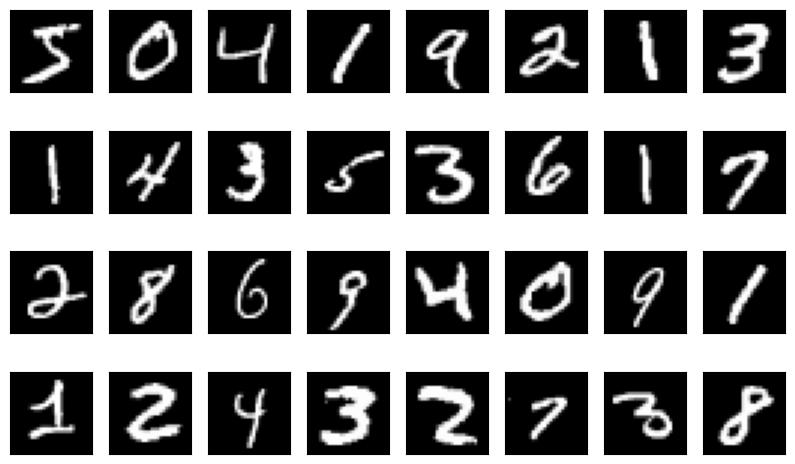

In [15]:
some_samples = train_x[:32, ...]
# Выбираем первые 32 изображения из обучающего набора train_x.
# Использование ... (ellipsis) означает, что берём все оставшиеся измерения,
# то есть shape будет (32, 28, 28, 1).

fig = plt.figure(figsize=(10, 6))
# Создаём пустую фигуру (холст) для графиков размером 10 на 6 дюймов.

for j in range(some_samples.shape[0]):
    # Цикл по индексам выбранных образцов (от 0 до 31, всего 32 изображения).
    ax = fig.add_subplot(4, 8, j+1)
    # Создаём подграфик (subplot) в сетке 4 строки на 8 столбцов.
    # j+1 нужен, так как индексация subplot начинается с 1.

    ax.imshow(some_samples[j,:,:,0], cmap='gray')
    # Отображаем изображение j-го образца.
    # some_samples[j,:,:,0] — вытаскиваем 2D-массив пикселей для j-го изображения (последний канал 0).
    # cmap='gray' задаёт отображение в оттенках серого.

    plt.xticks([]), plt.yticks([])
    # Убираем метки осей X и Y, чтобы не загромождать картинку цифрами.

plt.show()
# Показываем все 32 изображения в одном окне.


## Создание модели CNN

In [16]:
EMB_SIZE = 64
# Константа, задающая размер выходного вектора признаков (эмбеддинга) модели — 64.

model = tf.keras.models.Sequential([
    # Создаём последовательную модель Keras — слои идут друг за другом.

    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    # Свёрточный слой с 32 фильтрами размером 5x5.
    # padding='same' означает, что выходной размер будет таким же, как входной (паддинг добавляет нули по краям).
    # activation='relu' — функция активации ReLU (выдает 0, если вход <0, иначе вход).

    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    # Слой подвыборки (максимум) с окном 2x2 и шагом 2.
    # Уменьшает размерность карты признаков в 2 раза по ширине и высоте.

    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    # Второй свёрточный слой с 64 фильтрами 5x5, padding 'same' и активацией ReLU.

    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    # Ещё один слой максимального подвыборки 2x2, уменьшает размерность в 2 раза.

    tf.keras.layers.Flatten(),
    # "Выпрямляет" (разворачивает) многомерный тензор в одномерный вектор,
    # чтобы подать в полносвязные слои.

    tf.keras.layers.Dense(256, activation='relu'),
    # Полносвязный (Dense) слой с 256 нейронами и функцией активации ReLU.

    tf.keras.layers.Dropout(0.5),
    # Слой Dropout с вероятностью 0.5, который случайно "выключает" половину нейронов
    # при обучении для предотвращения переобучения.

    tf.keras.layers.Dense(EMB_SIZE, activation=None),
    # Последний полносвязный слой с EMB_SIZE (64) нейронами.
    # activation=None — линейная активация (без функции активации).
    # Этот слой выдаёт итоговый эмбеддинг — компактное представление изображения.
])


## Contrastive Loss

In [17]:
MARGIN = 10.0
# Пороговое значение (margin) для контрастивной потери.
# Оно задаёт минимальное расстояние между эмбеддингами разных классов,
# чтобы модель училась лучше их разделять.

def contastive_loss(embs, labels):
    # Функция вычисляет контрастивную потерю (contrastive loss) для пары эмбеддингов и меток.
    # embs — тензор эмбеддингов, shape (batch_size, EMB_SIZE).
    # labels — метки классов для каждого эмбеддинга.

    bs = embs.shape[0]
    # bs — размер батча (количество эмбеддингов).

    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    # Делим батч на две равные части, считаем, что первая половина соответствует "парам" с второй.
    # Например, batch из 64 → первые 32 в embs1, последние 32 в embs2.

    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]
    # Аналогично делим метки классов для этих двух частей.

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    # Вычисляем квадрат евклидова расстояния между соответствующими эмбеддингами пары.
    # tf.square — возводит в квадрат поэлементно,
    # tf.reduce_sum(..., axis=1) — суммирует по признакам, получается расстояние в квадрате для каждой пары.

    d = tf.sqrt(d2)
    # Берём квадратный корень, чтобы получить обычное евклидово расстояние.

    z = tf.cast(labels1 == labels2, tf.float32)
    # Создаём бинарный тензор: 1, если метки совпадают (пары одинакового класса), 0 — если разные.
    # tf.cast — преобразуем булевы значения в float32.

    return tf.reduce_mean(z * d2 + (1 - z) * tf.maximum(0, MARGIN - d) ** 2)
    # Вычисляем среднее значение функции потерь по батчу:
    # Для пар с одинаковыми метками (z=1) — штрафуем модель, если расстояние между эмбеддингами большое,
    # минимизируем квадрат расстояния d2 (чтобы эмбеддинги были ближе).
    #
    # Для пар с разными метками (z=0) — хотим, чтобы расстояние было не меньше MARGIN.
    # tf.maximum(0, MARGIN - d) — если расстояние меньше MARGIN, штрафуем квадратом разницы,
    # иначе штрафа нет (0).


## Подготовка пайплайна данных

In [18]:
BATCH_SIZE = 64
# Размер батча — количество образцов, обрабатываемых за один шаг обучения.
# 64 — стандартное значение, балансирующее скорость и качество обучения.

NUM_EPOCHS = 4
# Количество эпох — сколько раз вся обучающая выборка будет пройдена полностью.

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
# Создаём объект Dataset из TensorFlow из кортежа (train_x, train_y).
# Каждый элемент этого датасета — пара (изображение, метка).

train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
# Перемешиваем данные в датасете случайным образом.
# buffer_size = размер буфера для перемешивания — здесь весь тренировочный набор,
# чтобы добиться хорошего рандома.

train_ds = train_ds.repeat(NUM_EPOCHS)
# Повторяем датасет нужное число эпох.
# Иначе после одного прохода данные закончатся.

train_ds = train_ds.batch(BATCH_SIZE)
# Группируем данные по батчам размером 64.
# Это означает, что на каждом шаге обучения модель будет получать 64 изображения и метки сразу.


## Подготовка к обучению

In [19]:
LEARNING_RATE = 0.001
# Скорость обучения — параметр, который контролирует, насколько сильно обновляются веса модели
# на каждом шаге оптимизации. Малое значение = более медленное, но стабильное обучение.

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# Создаём оптимизатор Adam — современный и популярный алгоритм градиентного спуска,
# который адаптивно изменяет шаги обучения для каждого параметра.
# В качестве параметра передаём скорость обучения LEARNING_RATE.


## Обучение модели

In [20]:
%%time
# Jupyter-магия для измерения времени выполнения ячейки целиком.
# Покажет, сколько времени занял весь цикл обучения.

for iteration, (images, labels) in enumerate(train_ds):
    # Перебираем батчи из подготовленного датасета train_ds.
    # iteration — номер шага (батча),
    # images — батч изображений,
    # labels — соответствующие метки.

    with tf.GradientTape() as tape:
        # Создаём контекст GradientTape для автоматического вычисления градиентов.
        # Все операции внутри этого блока будут "записаны" для обратного прохода.

        embs = model(images)
        # Прогоняем батч изображений через модель,
        # получаем эмбеддинги (векторные представления).

        loss_value = contastive_loss(embs, labels)
        # Вычисляем значение функции потерь (контрастивной) для данного батча.

    grads = tape.gradient(loss_value, model.variables)
    # Автоматически вычисляем градиенты loss_value по всем параметрам модели (переменным).

    optimizer.apply_gradients(zip(grads, model.variables))
    # Обновляем веса модели с помощью оптимизатора Adam,
    # применяя рассчитанные градиенты.

    if iteration % 200 == 0:
        # Каждые 200 итераций выводим текущие значения потерь.

        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))
        # .numpy() преобразует тензор TensorFlow в число Python для вывода.


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


[0] Loss: 78.89668273925781
[200] Loss: 9.002910614013672
[400] Loss: 0.7873102426528931
[600] Loss: 2.2046265602111816
[800] Loss: 1.796646237373352
[1000] Loss: 0.8600448369979858
[1200] Loss: 1.5576725006103516
[1400] Loss: 0.40150290727615356
[1600] Loss: 1.0342544317245483
[1800] Loss: 0.7450039386749268
[2000] Loss: 1.7067769765853882
[2200] Loss: 1.2393559217453003
[2400] Loss: 2.547727108001709
[2600] Loss: 0.2987632155418396
[2800] Loss: 0.4205757975578308
[3000] Loss: 0.4098852872848511
[3200] Loss: 0.4286702871322632
[3400] Loss: 0.28556618094444275
[3600] Loss: 2.3192672729492188
CPU times: user 3min 51s, sys: 1.69 s, total: 3min 53s
Wall time: 3min 55s


## Получение эмбеддингов для тестовой выборки

In [21]:
test_embs = model(test_x)
# Прогоняем весь тестовый набор изображений test_x через обученную модель.
# На выходе получаем эмбеддинги — векторные представления изображений размером EMB_SIZE (64).
# test_embs — тензор формы (число тестовых изображений, 64).
# Эти эмбеддинги можно использовать для дальнейшего анализа, например, кластеризации или визуализации.


## Функция для визуализации эмбеддингов

In [22]:
def draw_embeddings(X_embedded, targets, labels):
    # Функция для визуализации двумерных эмбеддингов с помощью scatter plot,
    # где точки раскрашены по классам.

    plt.figure(figsize=(10, 10))
    # Создаём новую фигуру размером 10x10 дюймов для графика.

    for class_idx in range(np.max(targets) + 1):
        # Перебираем все классы от 0 до максимального номера класса.

        X_embedded_class = X_embedded[targets == class_idx, :]
        # Выбираем из X_embedded все точки, принадлежащие текущему классу class_idx.
        # targets == class_idx — булев массив, выбирающий нужные индексы.

        plt.scatter(X_embedded_class[:, 0], X_embedded_class[:, 1])
        # Строим точечный график (scatter) для выбранных точек по первым двум координатам.

    plt.legend(labels, loc='best')
    # Добавляем легенду с названиями классов.
    # labels — список названий классов, loc='best' автоматически выбирает оптимальное расположение.

    plt.grid(True)
    # Включаем отображение сетки на графике для удобства чтения.


## Визуализация образцов MNIST в 2D пространстве с помощью TSNE

In [23]:
test_x_flat = test_x.reshape(-1, 28*28)
# Преобразуем тестовые изображения из формы (число образцов, 28, 28, 1)
# в двумерный массив (число образцов, 784),
# то есть "разворачиваем" каждое 28x28 изображение в вектор длины 784 пикселя.
# -1 автоматически подставляет количество образцов.

test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat[:1000])
# Применяем алгоритм t-SNE для снижения размерности первых 1000 изображений с 784 до 2.
# n_components=2 означает, что выход будет двумерным (для удобной визуализации).
# fit_transform одновременно обучает модель и преобразует данные.

labels_for_viz = test_y[:1000]
# Берём соответствующие метки первых 1000 тестовых изображений для дальнейшей визуализации.


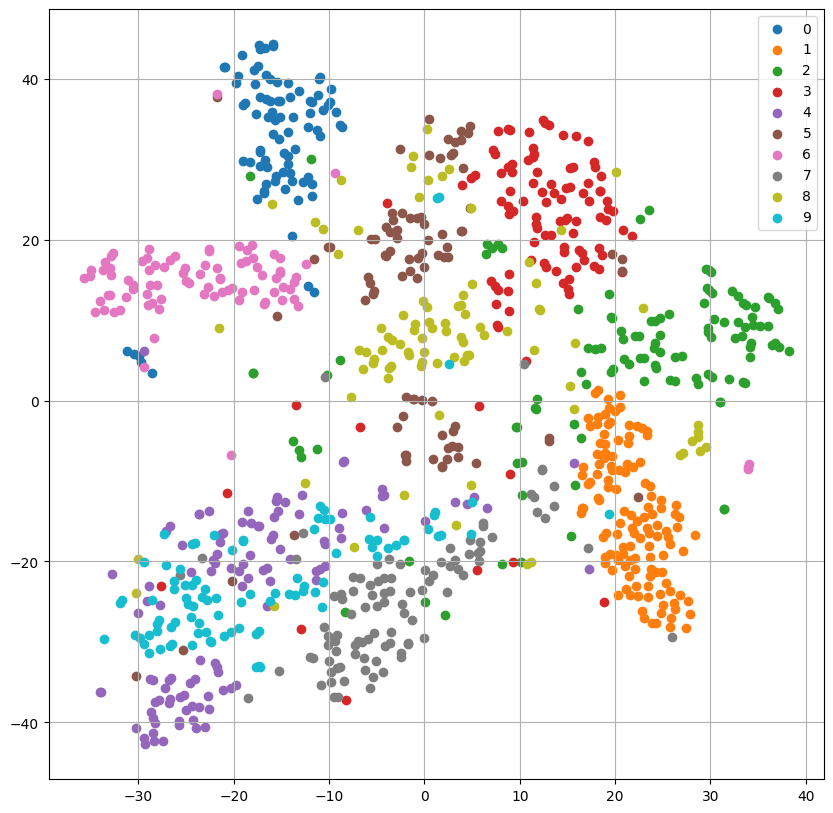

In [24]:
draw_embeddings(test_x_2D, labels_for_viz, list(range(10)))
# Вызов функции визуализации эмбеддингов draw_embeddings,
# где:
# test_x_2D — двумерные координаты изображений после снижения размерности (t-SNE),
# labels_for_viz — метки классов для этих изображений,
# list(range(10)) — список меток классов от 0 до 9 (цифры MNIST),
# который будет использован в легенде графика.


## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [25]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:1000])
# Применяем алгоритм t-SNE к первым 1000 эмбеддингам, полученным моделью.
# n_components=2 означает, что мы уменьшаем размерность с EMB_SIZE (64) до 2 для визуализации.

labels_for_viz = test_y[:1000]
# Берём метки для первых 1000 тестовых изображений,
# чтобы использовать их для цветовой маркировки на графике.


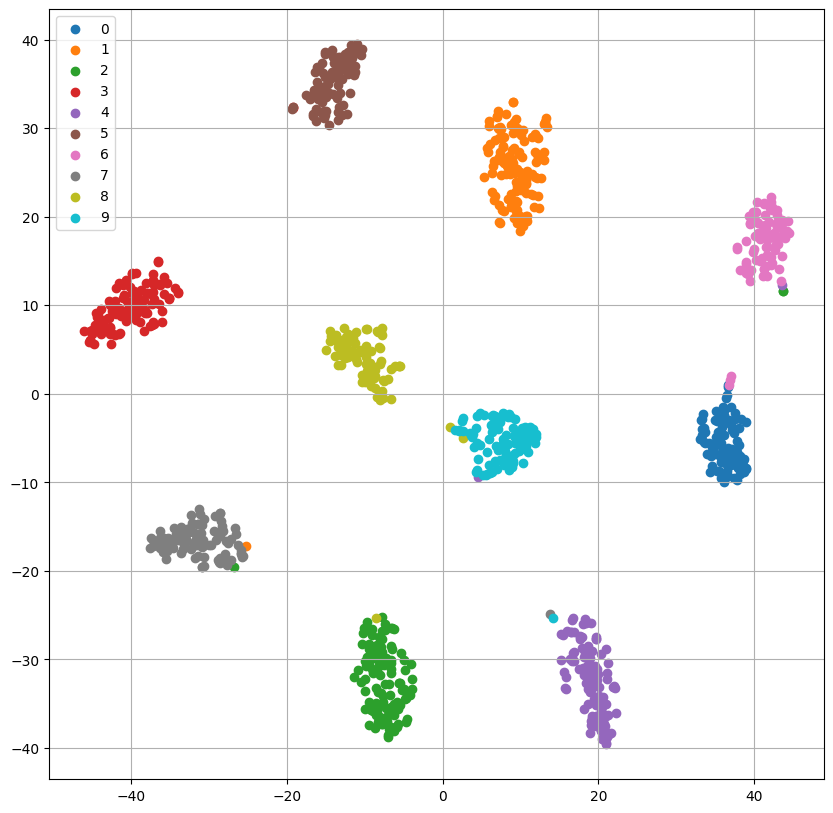

In [26]:
draw_embeddings(test_embs_2D, labels_for_viz, list(range(10)))
# Визуализируем двумерные эмбеддинги, полученные моделью,
# где точки окрашены в цвета согласно меткам классов (0–9),
# а легенда содержит цифры классов для удобства интерпретации.


## Тестирование на новых данных

In [27]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    # Импортируем библиотеки внутри функции, чтобы она была автономной.
    # imageio — для чтения изображений из файла.
    # resize из skimage.transform — для изменения размера изображения.

    img = imageio.imread(fpath, pilmode="RGB")
    # Читаем изображение из файла по пути fpath.
    # pilmode="RGB" — гарантируем, что изображение будет в цветном формате RGB.

    img = img.astype(np.float32) / 255
    # Преобразуем пиксели в тип с плавающей точкой и нормируем значения в диапазон [0, 1].

    img = resize(img, (28, 28), order=3, mode='reflect', anti_aliasing=True)
    # Изменяем размер изображения на 28x28 пикселей (размер MNIST).
    # order=3 — используем кубическую интерполяцию для сглаживания.
    # mode='reflect' — при выходе за границы отражаем изображение для заполнения.
    # anti_aliasing=True — применяем фильтрацию для уменьшения искажения.

    img = (1. - img).astype(np.float32)
    # Инвертируем цвета: меняем яркость на обратную (чёрный становится белым и наоборот).
    # Приводим результат к float32.

    img = np.mean(img, axis=2)
    # Преобразуем RGB в одноцветное изображение,
    # усредняя значения по цветовым каналам (получаем оттенки серого).

    img = np.reshape(img, (28, 28, 1))
    # Меняем форму массива, добавляя размерность канала,
    # чтобы изображение было совместимо с моделью (28x28x1).

    return img
    # Возвращаем подготовленное изображение — нормализованное и готовое для подачи в модель.

img_a1 = load_and_prepare_image('symbol_a1.png')
img_a2 = load_and_prepare_image('symbol_a2.png')
img_b1 = load_and_prepare_image('symbol_b1.png')
# Загружаем и подготавливаем три изображения из файлов 'symbol_a1.png', 'symbol_a2.png' и 'symbol_b1.png'.


/tmp/ipython-input-27-3130698393.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fpath, pilmode="RGB")


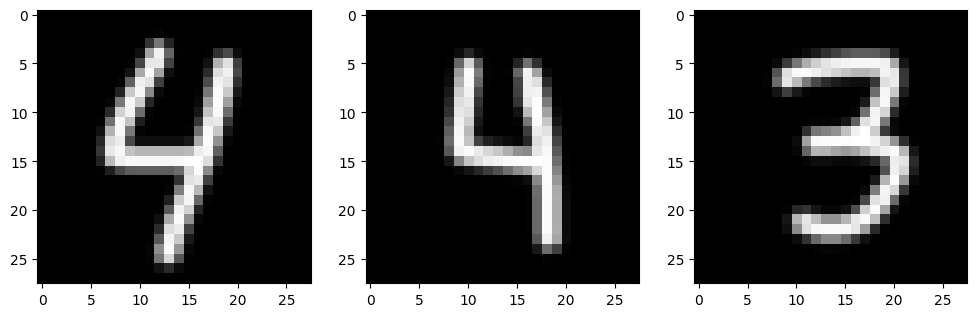

In [28]:
fig = plt.figure(figsize=(12, 4))
# Создаём фигуру (холст) размером 12 на 4 дюйма для размещения трёх изображений в ряд.

ax = fig.add_subplot(1, 3, 1)
# Создаём первый подграфик в сетке 1 строка, 3 столбца, позиция 1.
ax.imshow(img_a1[:, :, 0], cmap='gray')
# Отображаем первое изображение (img_a1) в оттенках серого.
# img_a1[:,:,0] — берём единственный канал изображения.

ax = fig.add_subplot(1, 3, 2)
# Создаём второй подграфик в позиции 2.
ax.imshow(img_a2[:, :, 0], cmap='gray')
# Отображаем второе изображение.

ax = fig.add_subplot(1, 3, 3)
# Создаём третий подграфик в позиции 3.
ax.imshow(img_b1[:, :, 0], cmap='gray')
# Отображаем третье изображение.

plt.show()
# Показываем созданную фигуру с тремя изображениями в одной строке.


## Получение эмбеддингов для новых данных

In [29]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))
# Объединяем три изображения (img_a1, img_a2, img_b1) в один батч с помощью np.stack по оси 0,
# получается массив формы (3, 28, 28, 1) — 3 изображения, каждое 28x28 с 1 каналом.
# Прогоняем батч через модель, чтобы получить эмбеддинги (векторные представления) для каждого изображения.
# new_embs — тензор формы (3, EMB_SIZE), где EMB_SIZE=64 — размер эмбеддинга.


## Вычисление расстояний между эмбеддингами

In [30]:
def diff(e1, e2):
    # Функция вычисляет евклидово расстояние между двумя векторами эмбеддингов e1 и e2.
    return np.sum((e1 - e2)**2) ** 0.5
    # (e1 - e2)**2 — поэлементное возведение разницы в квадрат,
    # np.sum(...) — сумма квадратов,
    # ** 0.5 — извлечение квадратного корня (евклидово расстояние).

emb1 = new_embs[0, :]
emb2 = new_embs[1, :]
emb3 = new_embs[2, :]
# Извлекаем эмбеддинги трёх изображений из батча.

print('A1 <-> A2: ', diff(emb1, emb2))
# Выводим расстояние между эмбеддингами img_a1 и img_a2.

print('A2 <-> B1: ', diff(emb2, emb3))
# Выводим расстояние между эмбеддингами img_a2 и img_b1.

print('A1 <-> B1: ', diff(emb1, emb3))
# Выводим расстояние между эмбеддингами img_a1 и img_b1.


A1 <-> A2:  2.043642
A2 <-> B1:  17.50515
A1 <-> B1:  15.74543
